In [55]:
from TCFile import TCFile
import numpy as np
import torch
import cv2
from torchvision import models
import utils

def process(path, time, model, mini_model, crop_size=(160,160), adaptive_crop=False, overlap=True, stride_proportion=0.5,
            wanted_patches=[], background_vote=False):
    # Load                                                                                    & prep data
    file = TCFile(path, '2DMIP')
    crop_size = crop_size

    slice_2d = utils.resize_tomogram_mip(
        file[time],
        data_resolution=file.data_resolution,
        target_resolution=0.1632,
        mode='mip'
    )

    if adaptive_crop:
        # Adjust the patch size if you want the patches to fit the image nicely
        residual = slice_2d.shape[0] % crop_size[0]
        fit = slice_2d.shape[0] // crop_size[0]
        adapt = residual // fit if fit > 0 else 0
        crop_size = (crop_size[0] + adapt, crop_size[1] + adapt)
        stride = int(crop_size[0]*stride_proportion)

    base_image = slice_2d.copy()
    # base_image = utils.image_normalization(base_image, min=1.33, max=1.4)

    # Normal PyTorch model prep
    transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
    mini_transform = models.ResNet50_Weights.IMAGENET1K_V2.transforms()

    model = model.cuda().eval()
    mini_model = mini_model.cuda().eval()

    # We'll store class votes for each pixel here: (H, W, num_classes)
    num_classes = 1+5  # Adjust if you actually have a different number
    label_counts = np.zeros((base_image.shape[0], base_image.shape[1], num_classes), dtype=np.int32)
    patch_layer = np.zeros((base_image.shape[0], base_image.shape[1]), dtype=np.int32)
    
    patch_coord = []
    wanted_patches = wanted_patches
    wanted_probabilities = []
    wanted_images = []
    
    if overlap:
        # Overlapping patches: define a smaller stride
        # e.g. half the patch size in each dimension
        stride_h = stride_w = stride
        patch_num = 0

        for top in range(0, base_image.shape[0] - crop_size[0] + 1, stride_h):
            for left in range(0, base_image.shape[1] - crop_size[1] + 1, stride_w):
                patch_coord.append((top, left, crop_size[0]))
                # Extract patch
                cropped = base_image[top:top+crop_size[0], left:left+crop_size[1]]

                # Clamp intensities (like your code)
                cropped = np.clip(cropped, 1.33, 1.40)
                cropped = utils.image_normalization(cropped, min=1.33, max=1.40)

                # Decide if we run the main model or the mini_model logic
                temp = cropped.copy()
                temp[temp < 45] = 0
                temp[temp > 45] = 1
                proportion = np.count_nonzero(temp == 1) / (np.count_nonzero(temp == 0) + np.count_nonzero(temp == 1))

                if proportion < 0.05:
                    # Use mini_model to check necrosis
                    mini_temp = cv2.equalizeHist(cropped.astype(np.uint8))
                    mini_temp = torch.from_numpy(mini_temp).repeat(3, 1, 1).float()
                    mini_temp = mini_transform(mini_temp).cuda()

                    is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()

                    if is_necrosis == 1:
                        # If necrosis, run the main model
                        image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                        image_tensor = transform(image_tensor).cuda()
                        output = model(image_tensor.unsqueeze(0)).cpu()
                        _, pred = torch.max(output, 1)
                        class_label = pred.item() + 1  # 0..(num_classes-1)
                    else:
                        class_label = 0  # or some "background" label
                else:
                    # Directly run main model
                    image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                    image_tensor = transform(image_tensor).cuda()
                    output = model(image_tensor.unsqueeze(0)).cpu()
                    _, pred = torch.max(output, 1)
                    class_label = pred.item() + 1
                    
                
                if patch_num in wanted_patches:
                    wanted_probabilities.append(output.detach().numpy())
                    wanted_images.append(base_image[top:top+crop_size[0], left:left+crop_size[1]])

                # Add a vote for this class in label_counts
                label_counts[top:top+crop_size[0], left:left+crop_size[1], class_label] += 1
                patch_layer[top:top+crop_size[0], left:left+crop_size[1]] = patch_num
                patch_num += 1
                
    else:
        # Original no-overlap approach
        patches = utils.crop_patch(slice_2d, crop_size=crop_size, overlap=False)
        patch_num = 0
        for patch_index, patch in enumerate(patches):
            top, left = patch[0], patch[1]
            patch_coord.append((top, left, crop_size[0]))
            cropped = base_image[top:top+crop_size[0], left:left+crop_size[1]]

            cropped = np.clip(cropped, 1.33, 1.40)
            cropped = utils.image_normalization(cropped, min=1.33, max=1.40)

            temp = cropped.copy()
            temp[temp < 45] = 0
            temp[temp > 45] = 1
            proportion = np.count_nonzero(temp == 1) / (np.count_nonzero(temp == 0) + np.count_nonzero(temp == 1))

            if proportion < 0.05:
                mini_temp = cv2.equalizeHist(cropped.astype(np.uint8))
                mini_temp = torch.from_numpy(mini_temp).repeat(3, 1, 1).float()
                mini_temp = mini_transform(mini_temp).cuda()
                is_necrosis = torch.max(mini_model(mini_temp.unsqueeze(0)), 1)[1].item()

                if is_necrosis == 1:
                    image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                    image_tensor = transform(image_tensor).cuda()
                    output = model(image_tensor.unsqueeze(0)).cpu()
                    _, pred = torch.max(output, 1)
                    class_label = pred.item() + 1
                else:
                    class_label = 0
            else:
                image_tensor = torch.from_numpy(cropped).repeat(3, 1, 1).float()
                image_tensor = transform(image_tensor).cuda()
                output = model(image_tensor.unsqueeze(0)).cpu()
                _, pred = torch.max(output, 1)
                class_label = pred.item() + 1
                
                
            if patch_num in wanted_patches:
                wanted_probabilities.append(output.detach().numpy())
                wanted_images.append(base_image[top:top+crop_size[0], left:left+crop_size[1]])
                
            label_counts[top:top+crop_size[0], left:left+crop_size[1], class_label] += 1
            patch_layer[top:top+crop_size[0], left:left+crop_size[1]] = patch_num
            patch_num += 1
    # Final pixelwise label = most frequent vote + 1 (if you want 1-based classes)
    # label_image = np.argmax(label_counts, axis=-1)
    
    # --- MODIFIED FINAL LABEL ASSIGNMENT ---
    # Final pixelwise label assignment with background priority

    # Calculate the standard argmax first (most frequent vote overall)
    provisional_label_image = np.argmax(label_counts, axis=-1)

    if background_vote:
        # Identify pixels where at least one patch voted for background (class 0)
        # label_counts[:, :, 0] accesses the counts for class 0 for all pixels
        total = np.sum(label_counts, axis=2)
        has_background_vote = 0.15 < label_counts[:, :, 0]/total

        # Initialize the final label image with the provisional result
        label_image = provisional_label_image.copy()

        # Override: wherever a background vote exists, set the final label to 0
        label_image[has_background_vote] = 0
        # --- END OF MODIFIED SECTION ---
    else:
        label_image = provisional_label_image.copy()

    return base_image, label_image, patch_layer, patch_coord, wanted_probabilities, wanted_images


In [56]:
from tqdm import tqdm
import torch
from torchvision import models
import utils
import numpy as np

path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\240808.200653.death_B4C4B5.005.Group2.C4.T001P01.TCF"
class_num = 5
model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\test_5_classes_22.032991_0.9728_sota.pth"
mini_model_path = r"C:\rkka_Projects\cell_death_v2\trained_models\mini_ai_epoch_9_0.000861_1.0000.pth"
file = TCFile(path, '2DMIP')
# Load Model
model = models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 5)
)
model.load_state_dict(torch.load(model_path))

# Load mini Model
mini_model = models.resnet50(pretrained=True)
num_features = mini_model.fc.in_features
mini_model.fc = torch.nn.Sequential(
    torch.nn.Dropout(0.2),
    torch.nn.Linear(num_features, 2)
)
mini_model.load_state_dict(torch.load(mini_model_path))

# Process
base_stack = []
label_stack = []
probabilities_stack = []

times = [8]

# wanted_patches = [110, 334, 329, 258, 192]
# wanted_patches = [0]

# for i in tqdm(range(len(file))):
for i in tqdm(times):
    # base_image, label_image = process(path, i, model, mini_model, adaptive_crop=True)
    base_image, label_image, patch_layer, patch_coord, wanted_probabilities, wanted_images = process(path, i, model, mini_model, 
                                                                                                     crop_size=(160,160),
                                      adaptive_crop=True, overlap=False, stride_proportion=0.1, wanted_patches=[],
                                      background_vote=True)
    base_stack.append(base_image)
    label_stack.append(label_image)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-d

In [58]:
viewer.add_image(np.array(base_stack))
viewer.add_labels(patch_layer)

<Labels layer 'patch_layer' at 0x296b803d400>

In [1]:
from tqdm import tqdm
from TCFile import TCFile
import utils
import numpy as np

path = r"C:\rkka_Projects\cell_death_v2\Data\Large_FOV\240808.200653.death_B4C4B5.005.Group2.C4.T001P01.TCF"
file = TCFile(path, '2DMIP')
base_stack_array = np.array([utils.resize_tomogram_mip(f, file.data_resolution, 0.1632, 'mip') for f in file])

In [2]:
import napari
viewer = napari.Viewer()

In [59]:
from TCFile import TCFile
import numpy as np
import cv2

time = 8
center = (900, 145)

base = base_stack_array[0].copy()
# viewer.add_image(base_stack)

colors = ['Blue', 'Green', 'Red']

ch0_list = []
ch1_list = []
ch2_list = []
for i in range(3):
    file = TCFile(path, '3DFL', channel=i, only_one=False)
    temp = np.max(file[time], axis=0)
    temp = cv2.resize(temp, dsize=base.shape)
    if i==0:
        ch0_list.append(temp)
    elif i==1:
        ch1_list.append(temp)
    elif i==2:
        ch2_list.append(temp)
            
ch0_stack = np.array(ch0_list)
ch1_stack = np.array(ch1_list)
ch2_stack = np.array(ch2_list)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

ch0 = ch0_stack[0] / 282.75906
ch1 = ch1_stack[0] / 125.01688
ch2 = ch2_stack[0] / 4.676991

# --- 각 채널별 색상 정의 (0-255 범위) ---
color_ch0 = np.array([0, 0, 255], dtype=np.uint8)
color_ch1 = np.array([0, 255, 0], dtype=np.uint8) # 초록색이 강한 노란빛
color_ch2 = np.array([255, 0, 0], dtype=np.uint8) # 빨간색이 강한 주황빛

# --- 빈 RGB 이미지 생성 (0-1 범위의 float 타입으로 시작) ---
# 나중에 0-255 범위로 변환하고 uint8로 캐스팅할 예정
# 오버플로우를 방지하기 위해 float으로 계산 후 클리핑
output_image_float = np.zeros((ch0.shape[0], ch0.shape[1], 3), dtype=float)

# --- 각 채널의 색상 적용 및 오버레이 ---
# ch0 (Blue)
# np.newaxis를 사용하여 (height, width) 배열을 (height, width, 1)로 만들어 브로드캐스팅 가능하게 함
output_image_float += ch0[..., np.newaxis] * (color_ch0 / 255.0)

# ch1 (Green-Yellow)
output_image_float += ch1[..., np.newaxis] * (color_ch1 / 255.0)

# ch2 (Red-Orange)
output_image_float += ch2[..., np.newaxis] * (color_ch2 / 255.0)

# --- 정규화 및 0-255 범위로 변환 ---
# 각 채널 강도가 이미 [0,1]로 정규화되어 있고, 색상 값도 [0,1]로 스케일링하여 곱했으므로,
# 합산된 결과가 1.0을 초과할 수 있습니다. (예: 모든 채널이 최대 강도인 경우)
# 따라서 [0,1] 범위로 클리핑하거나, 최대값으로 나누어 다시 정규화할 수 있습니다.
# 여기서는 간단히 [0,1]로 클리핑합니다.
output_image_float = np.clip(output_image_float, 0, 1)

# 0-255 범위로 스케일링하고 uint8 타입으로 변환
output_image_uint8 = (output_image_float * 255).astype(np.uint8)
output_image_uint8[:,:,1] = np.clip(output_image_uint8[:,:,1], 5, 255)

image = output_image_uint8[center[0]-75:center[0]+75, center[1]-120:center[1]+105]
image = Image.fromarray(image)
image.save(f'figures/figure4/cell_4h_flu_{0}.png')

In [73]:
viewer.add_image(output_image_uint8)

<Image layer 'output_image_uint8 [2]' at 0x29699711fa0>

In [90]:
patch_coord[110]

(820, 0, 164)

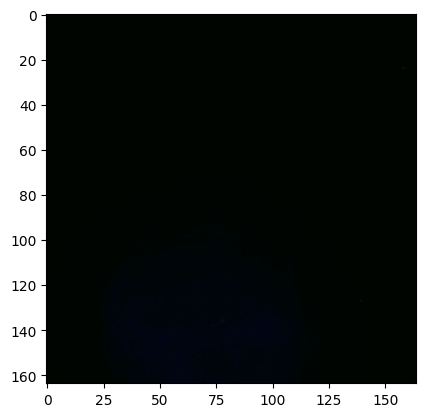

In [85]:
plt.imshow(output_image_uint8[2296:2296+164, 3444:3444+164])

In [91]:
image = output_image_uint8[820:820+164, 0:0+164]
image = Image.fromarray(image)
image.save(f'figures/figure4/cell_4h_flu_b.png')

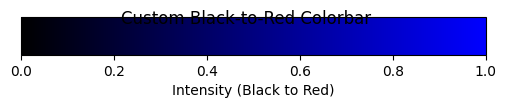

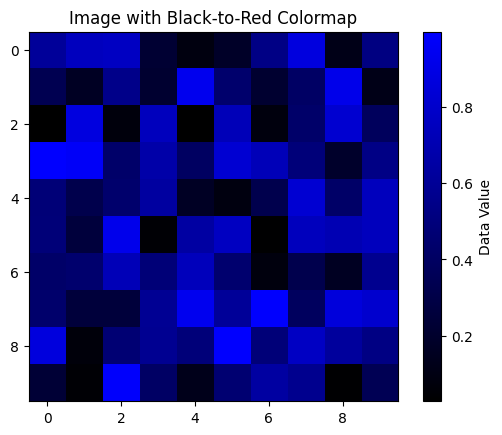

In [83]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# 1. Define the colors for the colormap
#    The list contains tuples of (value, color).
#    Values should be normalized between 0 and 1.
#    For a simple black-to-red, we define black at 0 and red at 1.
colors = [(0, "black"), (1, "blue")]
cmap_name = 'black_to_green'
cm = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

# 2. Create a figure and an axes for the colorbar
fig, ax = plt.subplots(figsize=(6, 1)) # Adjust figsize as needed
fig.subplots_adjust(bottom=0.5) # Adjust layout to make space for the colorbar

# 3. Create a ScalarMappable
#    This object maps normalized data values (0-1) to the colormap.
#    We need some dummy data for the normalization.
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
sm.set_array([]) # You can set an empty array or actual data

# 4. Add the colorbar to the figure
#    'cax=ax' uses the predefined axes for the colorbar.
#    'orientation="horizontal"' makes it a horizontal colorbar.
cbar = fig.colorbar(sm, cax=ax, orientation="horizontal")
cbar.set_label('Intensity (Black to Red)')

plt.suptitle('Custom Black-to-Red Colorbar', y=0.95)
plt.savefig('blue.svg', format='svg')
plt.show()

# --- To use this colormap in a plot (e.g., an image) ---
# Generate some sample data
data = np.random.rand(10, 10)

fig_img, ax_img = plt.subplots()
img = ax_img.imshow(data, cmap=cm) # Use the custom colormap 'cm'
fig_img.colorbar(img, label='Data Value')
ax_img.set_title('Image with Black-to-Red Colormap')
plt.show()